In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications import VGG19

In [ ]:
train_folder="/kaggle/input/cityscapes-image-pairs/cityscapes_data/train"
val_folder="/kaggle/input/cityscapes-image-pairs/cityscapes_data/val"
width = 256
height = 256
classes = 13
batch_size = 5
training_samples = len(os.listdir(train_folder))
testing_samples = len(os.listdir(val_folder))

In [ ]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)

    image = img[:,:256]
    scapes = img[:,256:]

    return image, scapes

In [ ]:
def bin_image(scapes):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_img = np.digitize(scapes, bins)
    return new_img

In [ ]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

In [ ]:
def give_color_to_seg_img(seg, n_classes=13):

    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)

    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [ ]:
def DataGenerator(path, batch_size=10, classes=13):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                #file = random.sample(files,1)[0]
                image, scapes = LoadImage(file, path)
                img_binned = bin_image(scapes)
                labels = getSegmentationArr(img_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

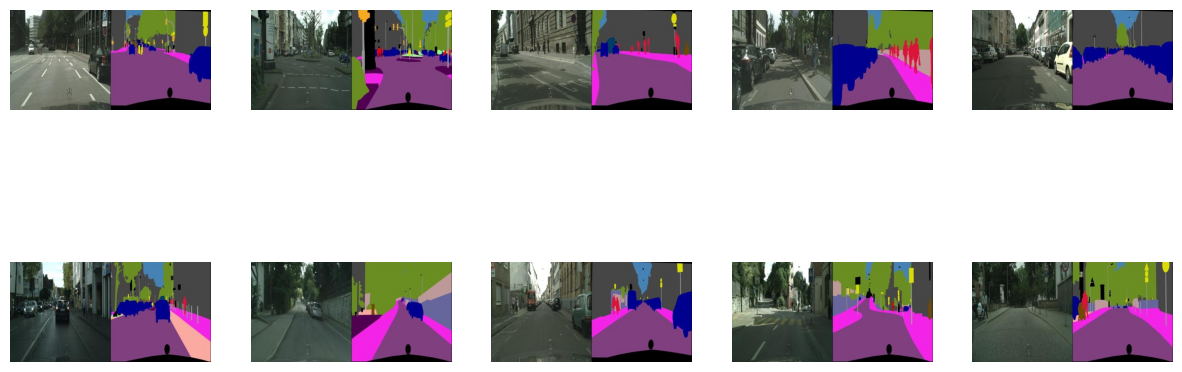

In [ ]:
# Path ke dataset segmentasi gambar
import matplotlib.pyplot as plt
train = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train'

# Tampilkan beberapa contoh gambar dan label segmentasinya
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, path in enumerate(os.listdir(train)[:10]):
    img = Image.open(os.path.join(train, path))
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

In [ ]:
train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(val_folder, batch_size=batch_size)

In [ ]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((5, 256, 256, 3), (5, 256, 256, 13))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(13, activation='softmax'))

In [ ]:
from keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Tambahan dropout
model.add(Dense(13, activation='softmax'))

In [ ]:
from keras.regularizers import l2

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))  # Regularisasi L2
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))  # Regularisasi L2
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(13, activation='softmax'))

In [ ]:
from keras.applications import VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(13, activation='softmax'))

In [ ]:
def crop(tensor1, tensor2):
    # Ambil dimensi tensor pertama
    h1, w1 = tensor1.shape[1], tensor1.shape[2]

    # Ambil dimensi tensor kedua
    h2, w2 = tensor2.shape[1], tensor2.shape[2]

    # Hitung perbedaan ukuran
    dh = abs(h1 - h2)
    dw = abs(w1 - w2)

    # Lakukan pemangkasan pada tensor agar memiliki dimensi yang sama
    if h1 > h2:
        tensor1 = tensor1[:, :h2, :]
    else:
        tensor2 = tensor2[:, :h1, :]

    if w1 > w2:
        tensor1 = tensor1[:, :, :w2]
    else:
        tensor2 = tensor2[:, :, :w1]

    return tensor1, tensor2

In [ ]:
def fcn(vgg, classes=13, fcn8=False):
    pool5 = vgg.get_layer('block5_pool').output
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output

    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)

    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)

    deconv_7 = Conv2DTranspose(classes, kernel_size=(2, 2), strides=(2, 2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2, 2), strides=(2, 2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8, 8), strides=(8, 8))(add_2)

    # Jika menggunakan fcn16, sesuaikan logika di sini
    if fcn8:
        output_layer = Activation('softmax')(deconv_9)
    else:
        # Jika tidak menggunakan fcn16, mungkin ada logika lain di sini
        output_layer = Activation('softmax')(deconv_8)

    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

In [ ]:
# Menggunakan FCN yang didefinisikan sebelumnya
model = fcn(base_model, fcn8=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

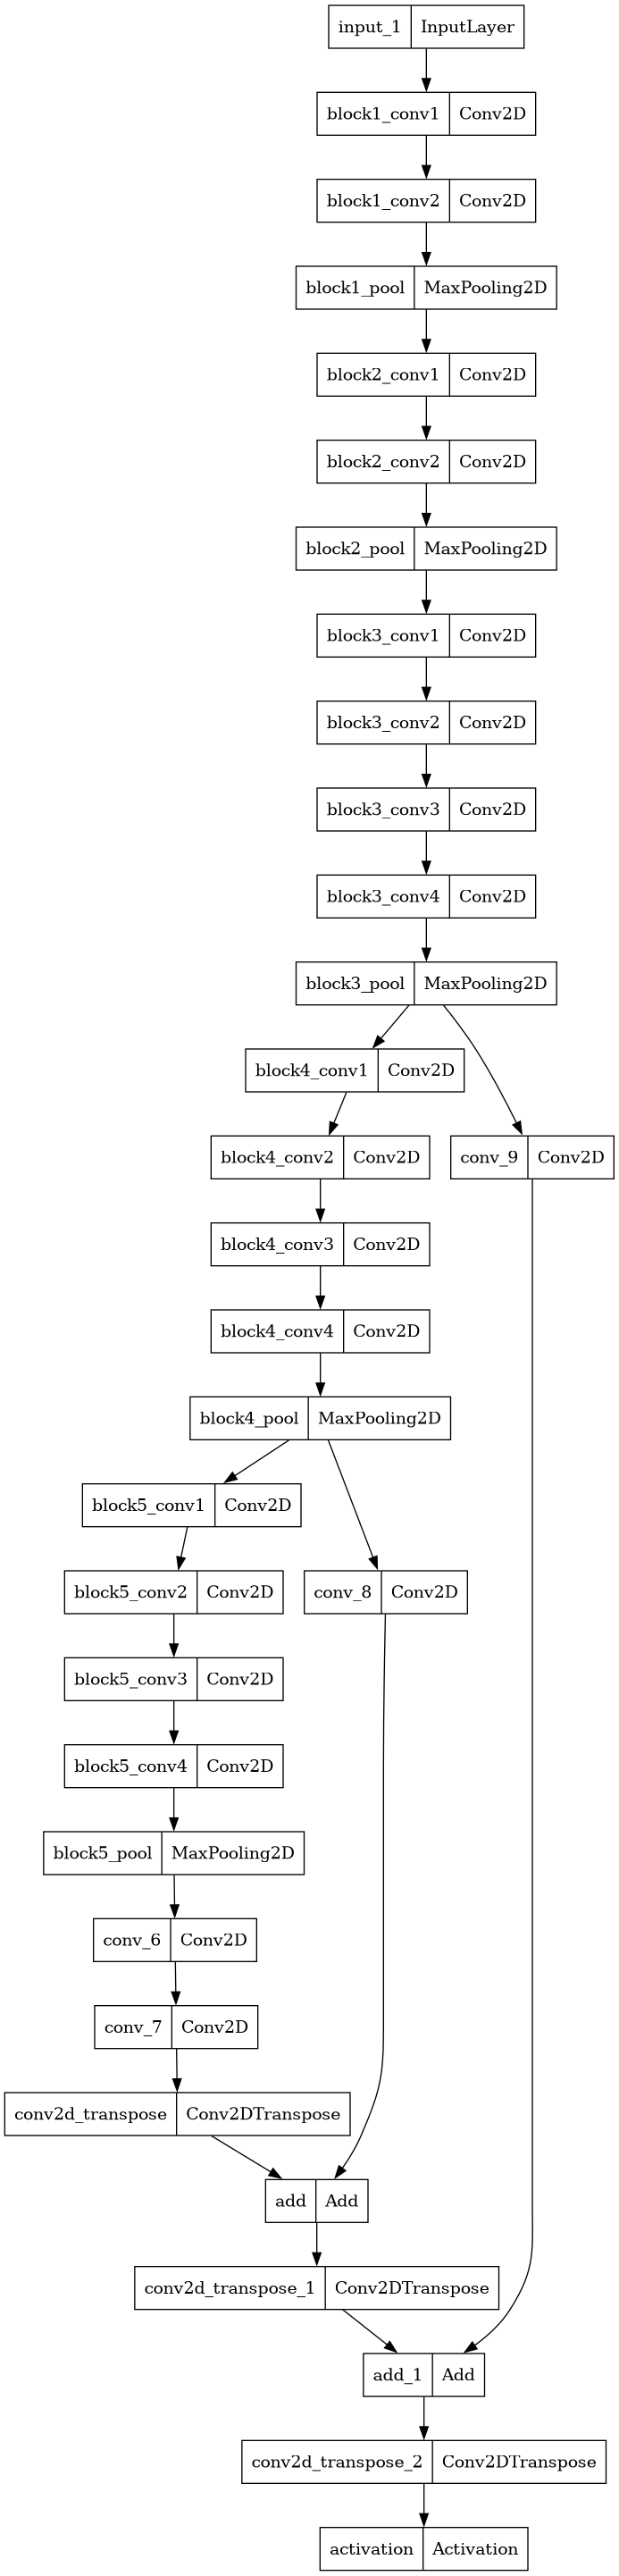

In [ ]:
plot_model(model)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = "VGG19_BAIK.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_gen, epochs=10, steps_per_epoch=training_samples//batch_size,
                    validation_data=val_gen, validation_steps=testing_samples//batch_size, use_multiprocessing=True)

Epoch 1/10
595/595 [==============================] - 453s 734ms/step - loss: 2.9240 - accuracy: 0.1691 - val_loss: 1.9118 - val_accuracy: 0.3822
Epoch 2/10
595/595 [==============================] - 443s 746ms/step - loss: 1.5332 - accuracy: 0.5092 - val_loss: 1.3196 - val_accuracy: 0.5778
Epoch 3/10
595/595 [==============================] - 441s 742ms/step - loss: 1.2312 - accuracy: 0.6415 - val_loss: 1.1731 - val_accuracy: 0.6847
Epoch 4/10
595/595 [==============================] - 459s 772ms/step - loss: 1.0835 - accuracy: 0.7094 - val_loss: 1.0709 - val_accuracy: 0.7155
Epoch 5/10
595/595 [==============================] - 456s 767ms/step - loss: 0.9925 - accuracy: 0.7337 - val_loss: 0.9970 - val_accuracy: 0.7307
Epoch 6/10
595/595 [==============================] - 474s 797ms/step - loss: 0.9333 - accuracy: 0.7485 - val_loss: 0.9441 - val_accuracy: 0.7455
Epoch 7/10
595/595 [==============================] - 521s 877ms/step - loss: 0.8845 - accuracy: 0.7596 - val_loss: 0.9170 -

In [ ]:
model.load_weights("VGG19_BAIK.h5")

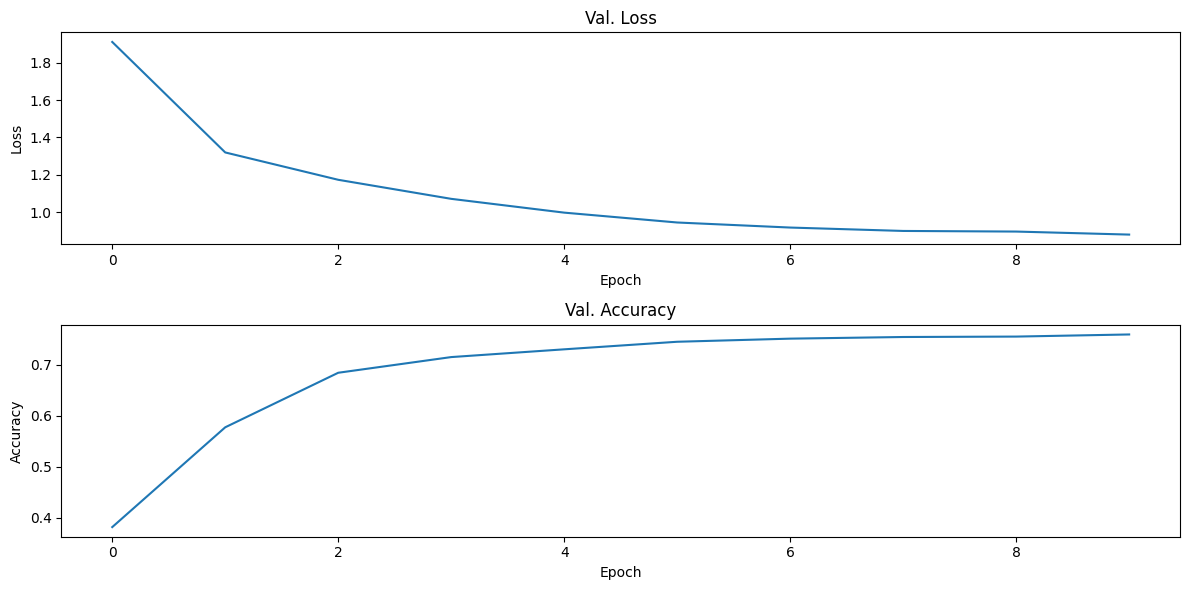

In [ ]:
loss = history.history["val_loss"]
acc = history.history["val_accuracy"] #accuracy

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

1/1 [==============================] - 1s 700ms/step


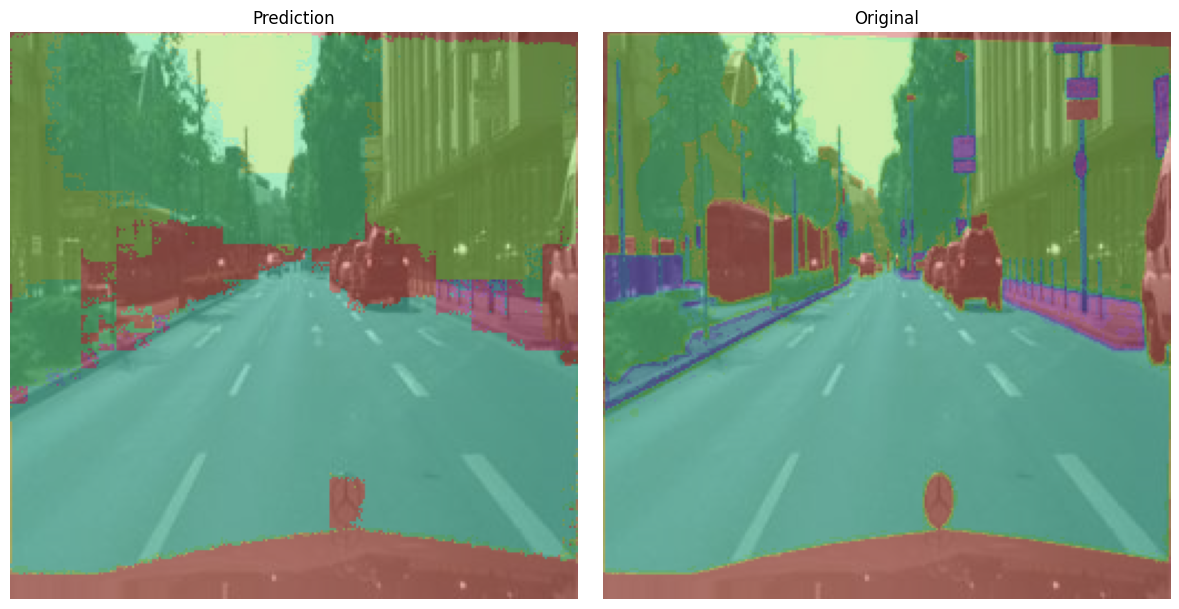

In [ ]:
#val_gen = DataGenerator(valid_folder)
max_show = 1
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)

    plot.figure(figsize=(12,6))
    plot.subplot(121)
    plot.title("Prediction")
    plot.imshow(predimg)
    plot.axis("off")
    plot.subplot(122)
    plot.title("Original")
    plot.imshow(trueimg)
    plot.axis("off")
    plot.tight_layout()
    plot.savefig("pred_"+str(i)+".png", dpi=150)
    plot.show()

In [ ]:
model.save('/kaggle/working/VGG19_BAIK.h5')

NameError: ignored